# Workload and AHT see the largest difference in forecast accuracy on the metric Mean Absolute Error (MAE) when comparing the old model to prophet.

The new Prophet model workload forecasts for RIS (MAE ~ 46 hours) compared to Old Model (MAE ~ 439 hours) have been closer to the actual handle times recieved by an average of 393 hours daily for the period of January 1st to January 18th, 2021.

This is a period of 10 days.

In [1]:
import pandas as pd
pd.DataFrame({'volume': [1238,2019,-780],
             'aht': [481,200,280],
             'workload (hours)': [439.1475, 
                                  46.342778,
                                  392.804722]}, 
             index=['old model',
                    'prophet',
                    'difference'])

,volume,aht,workload (hours)
old model,1238,481,439.147500
prophet,2019,200,46.342778
difference,-780,280,392.804722


In [20]:
def load_full_dataset(path):
    """
    given a dataset with all business units
    return and write to each csv
    """
    df = pd.read_csv(path)
    
    df.rename(columns={'ACTIVITY DATE':'date', 
                       'Sum of TOTAL TIME - AHT (sec)':'handle_time', 
                       'Sum of TOTAL TIME - AHT - FORECAST (sec)': 'handle_time_forecast', 
                       'Sum of VOLUME - RECEIVED': 'volume', 
                       'Sum of VOLUME - FORECAST': 'volume_forecast', 
                       'Sum of VOLUME - HANDLED': 'volume_handled'}, inplace=True)
    
    df.columns = [x.lower() for x in df.columns]
    
    return df

path = '../data/full_dataset.csv'
df = load_full_dataset(path)
df.tail()

,date,division,business unit,business line,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled
17977,2/11/2021,II Services and Operations,RIS,RIS,1351461.0,2343929.0,2528.0,3247.0,2002.0
17978,2/11/2021,II Services and Operations,RCS PHONES,RCS PHONES,301770.0,467815.0,572.0,602.0,403.0
17979,2/11/2021,II Services and Operations,SCS,BRO,341932.0,301244.0,542.0,418.0,480.0
17980,2/11/2021,II Services and Operations,SCS,PSG,773365.0,1533160.0,1284.0,1914.0,1084.0
17981,2/11/2021,II Services and Operations,SCS,BRO-Complex,111855.0,158041.0,164.0,201.0,158.0


In [21]:
def write_data(df, group='business line', 
forecast_list=['handle_time','handle_time_forecast', 
'volume', 'volume_forecast', 'volume_handled']):
    """
    take in a dataframe, query by business unit 
    and write to a csv
    """
    # iterate through the unique business lines
    groups = df[group].unique()
    for line in groups:
        data = df[df[group] == line][['date']+forecast_list]

        path = '../data/'+line+'_aht_vol.csv'
        path = path.replace(' ', '-')
        data.to_csv(path)
        print('wrote to '+path)

write_data(df)

wrote to ../data/WISE-Contractual_aht_vol.csv
wrote to ../data/CS-Alaska_aht_vol.csv
wrote to ../data/CS-John-Hancock_aht_vol.csv
wrote to ../data/CS-Maryland_aht_vol.csv
wrote to ../data/CS-National_aht_vol.csv
wrote to ../data/RIS_aht_vol.csv
wrote to ../data/RCS-PHONES_aht_vol.csv
wrote to ../data/BRO_aht_vol.csv
wrote to ../data/PSG_aht_vol.csv
wrote to ../data/BRO-Complex_aht_vol.csv


# Define methods for producing predictions and scoring

In [22]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
import datetime

def remove_holidays(df, path='../data/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    
def load_data(path):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv('../data/'+path, index_col=0,
                     parse_dates=['date'])
    
    # convert strings to numbers
#     df['volume_forecast'] = pd.to_numeric(df['volume_forecast'])
#     df['volume_handled'] = pd.to_numeric(df['volume_handled'])
    
    # create column for aht
    df = remove_holidays(df)
    df['aht'] = df['handle_time']/df['volume_handled']
    df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']
    df['abandonment_rate'] = (df['volume'] - df['volume_handled'])/df['volume']
    df['workload'] = df['handle_time']/3600


    df.index = df['date']
    display(df.tail(10))
    return df

def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """
    
    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    df = df[(df['aht'] > 400) | (df['aht'] < 900) | (df['handle_time'] > 500000)]
    
    # remove nulls
    df = df[df['aht'].notnull()]

    return df

def create_training_data(df, metric, start='2016-01-01', end='2020-06-01'):
    """
    takes in a dataframe and returns a filtered dataframe
    """
    
    df = df[(df['date'] >= start) & (df['date'] < end)]
    
    df = df[[metric]]
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

def train_model(df, ci=0.95):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """
    # create default prophet model
    m = Prophet(interval_width=ci, weekly_seasonality=True, 
                yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    
    return m


def get_validation_data(df, end_training, end_testing):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    df = remove_holidays(df)
    
    df = df[(df['date'] >= end_training) & (df['date'] < end_testing)]
    
    return df



def get_accuracy(df2,forecast, kpi, metric='mae'):
    """
    take in 2 dataframes df2 with original predictions and forecast with
    new predictions and return a dataframe of the MAE for each model and
    the difference between old model and prophet
    negative values indicate old model has less error.
    """
    if metric == 'mape':
        mae1 = mean_absolute_percentage_error(df2[kpi], df2[kpi+'_forecast'])
        mae2 = mean_absolute_percentage_error(df2[kpi], forecast['yhat'])
    else:
        mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
        mae2 = mean_absolute_error(df2[kpi], forecast['yhat'])
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[mae1,mae2,diff],
                 columns=['MAE'])

def get_performance(data, fields, start_train, start_test, end_test, metric='mae', ci=0.95):
    """
    take in data as a list of csv from each business unit
    fields are the kpis being predicted
    start and end is the start date and end date of testing
    
    TODO
        setup model diagnostics
        https://facebook.github.io/prophet/docs/diagnostics.html
    """
    
    # load a dictionary with dates for starting training
    date_dict = {'BRO-Complex_aht_vol.csv':'2018-10-01', 'BRO_aht_vol.csv': '2018-11-01', 
    'CS-Alaska_aht_vol.csv':'2016-01-01', 'CS-John-Hancock_aht_vol.csv':'2019-12-01', 
    'CS-Maryland_aht_vol.csv': '2017-11-01', 'CS-National_aht_vol.csv':'2016-11-01', 
    'PSG_aht_vol.csv':'2019-11-01', 'RCS-PHONES_aht_vol.csv':'2018-11-01', 
    'RIS_aht_vol.csv':'2016-03-10', 'WISE-Contractual_aht_vol.csv':'2016-11-01'}
    
    res = {}
    for b in data:
        # create a list for the scores of each kpi
        a = []
        print('*'*80)
        print(b)
        print('*'*80)
        for k in fields:
            bu = b
            kpi = k
            if bu[:3] == 'RIS':
                start_train = date_dict[b] 
#             start_train = date_dict[b]
            start = start_test
            end = end_test

            df = load_data(bu)
            
            df = clean_training_data(df)
            
            df2 = get_validation_data(df, end_training=start_test, end_testing=end_test)

            df = create_training_data(df, kpi, start=start_train, end=start_test)

            m = train_model(df, ci=ci)

            future = m.make_future_dataframe(periods=365)
            future = remove_holidays(future)
            forecast = m.predict(future)
            
            fig = m.plot(forecast)
            plt.title(k)
            fig2 = m.plot_components(forecast)
            plt.show()

            f = forecast[(forecast['ds'] >= start_test) & (forecast['ds'] < end_test)]
            
            f = f.reset_index(drop=True)
            df2 = df2.reset_index(drop=True)

            write_f = f[['ds','yhat_lower', 'yhat', 'yhat_upper']]
            
            write_f = pd.concat([write_f, df2[[k]]], 1)
            
            write_f['error_prophet'] = (write_f['yhat'] - write_f[k]).abs()
    
            if kpi != 'abandonment_rate':
                write_f['error_prophet'] = write_f['error_prophet'].round()
                write_f = pd.concat([write_f, df2[[k+'_forecast']]], 1)
                write_f['error_forecast'] = (write_f[k+'_forecast'] - write_f[k]).abs().round()
                write_f['diff'] = write_f['error_forecast'] - write_f['error_prophet']
                accuracy = get_accuracy(df2, f, kpi, metric=metric )
                a.append(accuracy)

                write_f.to_csv('../preds/'+k+'_'+b[:6]+'.csv')
            
#             else:
#                 write_f = pd.concat([write_f, df2[[k]]], 1)


            print(k)
            display(write_f)

        diff = None
        diff = pd.concat([x for x in a], axis=1)
        diff.columns = ['volume', 'aht', 'handle_time']
#         diff['handle_time'] /= 3600
#         diff.rename(columns={'handle_time': 'workload (hours)'}, inplace=True)
        print(metric, b)
            
        display(diff)
        
        res[b] = (m, diff, forecast[forecast['ds'] >= end_test])
    return res


********************************************************************************
RIS_aht_vol.csv
********************************************************************************


,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,abandonment_rate,workload
date,,,,,,,,,,
2021-01-29,2021-01-29,1612695.0,3279664.0,3086.0,4115.0,2203.0,732.044939,797.002187,0.286131,447.970833
2021-02-01,2021-02-01,1725448.0,3673814.0,4933.0,4905.0,2488.0,693.508039,748.993680,0.495642,479.291111
2021-02-02,2021-02-02,1644443.0,3415117.0,4130.0,4703.0,2420.0,679.521901,726.157134,0.414044,456.789722
2021-02-03,2021-02-03,1659492.0,2986328.0,3412.0,4133.0,2309.0,718.705933,722.556980,0.323271,460.970000
2021-02-04,2021-02-04,1588327.0,2779548.0,3081.0,3860.0,2279.0,696.940325,720.090155,0.260305,441.201944
2021-02-05,2021-02-05,1584398.0,2687062.0,2884.0,3726.0,2250.0,704.176889,721.165325,0.219834,440.110556
2021-02-08,2021-02-08,1583069.0,3352512.0,4176.0,4536.0,2303.0,687.394268,739.089947,0.448515,439.741389
2021-02-09,2021-02-09,1540143.0,2949450.0,3342.0,4034.0,2150.0,716.345581,731.147744,0.356673,427.817500
2021-02-10,2021-02-10,1494526.0,2576259.0,2709.0,3548.0,2020.0,739.864356,726.115840,0.254337,415.146111


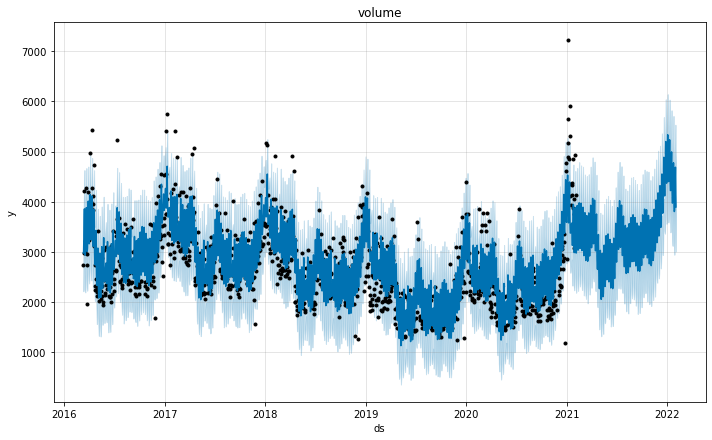

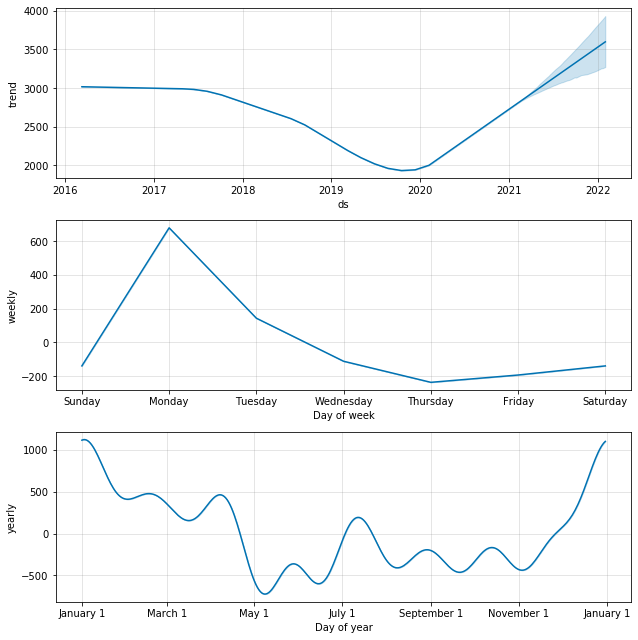

volume


,ds,yhat_lower,yhat,yhat_upper,volume,error_prophet,volume_forecast,error_forecast,diff
0,2021-02-03,2337.085380,3097.244220,3846.591020,3412.0,315.0,4133.0,721.0,406.0
1,2021-02-04,2187.258777,2977.467147,3767.600297,3081.0,104.0,3860.0,779.0,675.0
2,2021-02-05,2233.631360,3027.276789,3790.736950,2884.0,143.0,3726.0,842.0,699.0
3,2021-02-08,3170.024710,3924.644479,4671.326873,4176.0,251.0,4536.0,360.0,109.0
4,2021-02-09,2589.557306,3398.232679,4207.985013,3342.0,56.0,4034.0,692.0,636.0
5,2021-02-10,2314.579061,3152.107252,3929.917867,2709.0,443.0,3548.0,839.0,396.0
6,2021-02-11,2226.071563,3036.028453,3846.883984,2528.0,508.0,3247.0,719.0,211.0


,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,abandonment_rate,workload
date,,,,,,,,,,
2021-01-29,2021-01-29,1612695.0,3279664.0,3086.0,4115.0,2203.0,732.044939,797.002187,0.286131,447.970833
2021-02-01,2021-02-01,1725448.0,3673814.0,4933.0,4905.0,2488.0,693.508039,748.993680,0.495642,479.291111
2021-02-02,2021-02-02,1644443.0,3415117.0,4130.0,4703.0,2420.0,679.521901,726.157134,0.414044,456.789722
2021-02-03,2021-02-03,1659492.0,2986328.0,3412.0,4133.0,2309.0,718.705933,722.556980,0.323271,460.970000
2021-02-04,2021-02-04,1588327.0,2779548.0,3081.0,3860.0,2279.0,696.940325,720.090155,0.260305,441.201944
2021-02-05,2021-02-05,1584398.0,2687062.0,2884.0,3726.0,2250.0,704.176889,721.165325,0.219834,440.110556
2021-02-08,2021-02-08,1583069.0,3352512.0,4176.0,4536.0,2303.0,687.394268,739.089947,0.448515,439.741389
2021-02-09,2021-02-09,1540143.0,2949450.0,3342.0,4034.0,2150.0,716.345581,731.147744,0.356673,427.817500
2021-02-10,2021-02-10,1494526.0,2576259.0,2709.0,3548.0,2020.0,739.864356,726.115840,0.254337,415.146111


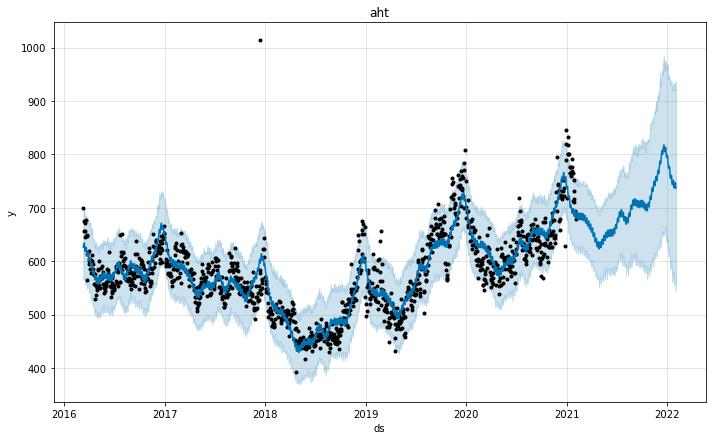

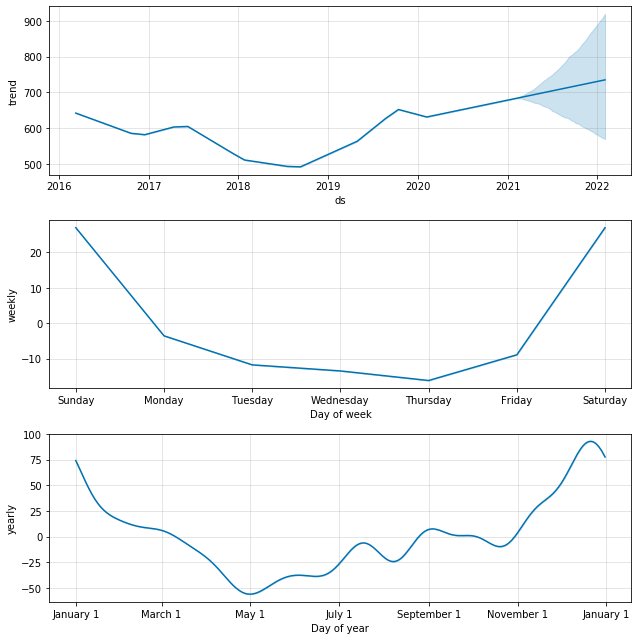

aht


,ds,yhat_lower,yhat,yhat_upper,aht,error_prophet,aht_forecast,error_forecast,diff
0,2021-02-03,628.342304,683.647838,743.379602,718.705933,35.0,722.556980,4.0,-31.0
1,2021-02-04,614.561765,680.529356,744.648677,696.940325,16.0,720.090155,23.0,7.0
2,2021-02-05,628.627468,687.404199,754.856348,704.176889,17.0,721.165325,17.0,0.0
3,2021-02-08,627.411124,691.745108,755.445619,687.394268,4.0,739.089947,52.0,48.0
4,2021-02-09,624.998295,683.244238,741.738346,716.345581,33.0,731.147744,15.0,-18.0
5,2021-02-10,619.283754,681.263175,745.031329,739.864356,59.0,726.115840,14.0,-45.0
6,2021-02-11,613.105222,678.322755,738.592892,675.055445,3.0,721.875269,47.0,44.0


,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,abandonment_rate,workload
date,,,,,,,,,,
2021-01-29,2021-01-29,1612695.0,3279664.0,3086.0,4115.0,2203.0,732.044939,797.002187,0.286131,447.970833
2021-02-01,2021-02-01,1725448.0,3673814.0,4933.0,4905.0,2488.0,693.508039,748.993680,0.495642,479.291111
2021-02-02,2021-02-02,1644443.0,3415117.0,4130.0,4703.0,2420.0,679.521901,726.157134,0.414044,456.789722
2021-02-03,2021-02-03,1659492.0,2986328.0,3412.0,4133.0,2309.0,718.705933,722.556980,0.323271,460.970000
2021-02-04,2021-02-04,1588327.0,2779548.0,3081.0,3860.0,2279.0,696.940325,720.090155,0.260305,441.201944
2021-02-05,2021-02-05,1584398.0,2687062.0,2884.0,3726.0,2250.0,704.176889,721.165325,0.219834,440.110556
2021-02-08,2021-02-08,1583069.0,3352512.0,4176.0,4536.0,2303.0,687.394268,739.089947,0.448515,439.741389
2021-02-09,2021-02-09,1540143.0,2949450.0,3342.0,4034.0,2150.0,716.345581,731.147744,0.356673,427.817500
2021-02-10,2021-02-10,1494526.0,2576259.0,2709.0,3548.0,2020.0,739.864356,726.115840,0.254337,415.146111


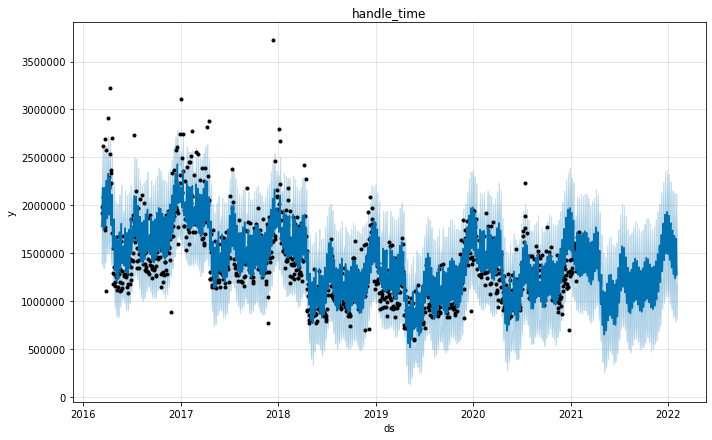

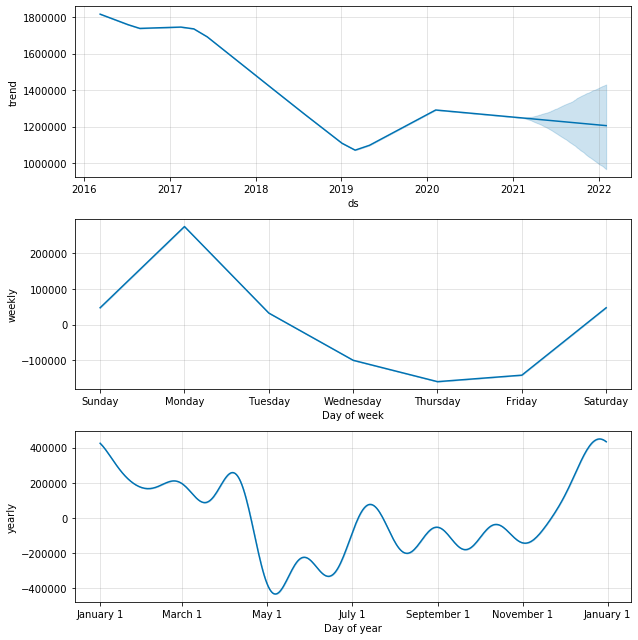

handle_time


,ds,yhat_lower,yhat,yhat_upper,handle_time,error_prophet,handle_time_forecast,error_forecast,diff
0,2021-02-03,9.505395e+05,1.316222e+06,1.748465e+06,1659492.0,343270.0,2986328.0,1326836.0,983566.0
1,2021-02-04,8.784695e+05,1.255851e+06,1.651230e+06,1588327.0,332476.0,2779548.0,1191221.0,858745.0
2,2021-02-05,8.960736e+05,1.273735e+06,1.676719e+06,1584398.0,310663.0,2687062.0,1102664.0,792001.0
3,2021-02-08,1.298890e+06,1.691154e+06,2.120285e+06,1583069.0,108085.0,3352512.0,1769443.0,1661358.0
4,2021-02-09,1.056956e+06,1.451632e+06,1.837149e+06,1540143.0,88511.0,2949450.0,1409307.0,1320796.0
5,2021-02-10,9.098666e+05,1.322202e+06,1.715726e+06,1494526.0,172324.0,2576259.0,1081733.0,909409.0
6,2021-02-11,8.774052e+05,1.265277e+06,1.654971e+06,1351461.0,86184.0,2343929.0,992468.0,906284.0


,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,abandonment_rate,workload
date,,,,,,,,,,
2021-01-29,2021-01-29,1612695.0,3279664.0,3086.0,4115.0,2203.0,732.044939,797.002187,0.286131,447.970833
2021-02-01,2021-02-01,1725448.0,3673814.0,4933.0,4905.0,2488.0,693.508039,748.993680,0.495642,479.291111
2021-02-02,2021-02-02,1644443.0,3415117.0,4130.0,4703.0,2420.0,679.521901,726.157134,0.414044,456.789722
2021-02-03,2021-02-03,1659492.0,2986328.0,3412.0,4133.0,2309.0,718.705933,722.556980,0.323271,460.970000
2021-02-04,2021-02-04,1588327.0,2779548.0,3081.0,3860.0,2279.0,696.940325,720.090155,0.260305,441.201944
2021-02-05,2021-02-05,1584398.0,2687062.0,2884.0,3726.0,2250.0,704.176889,721.165325,0.219834,440.110556
2021-02-08,2021-02-08,1583069.0,3352512.0,4176.0,4536.0,2303.0,687.394268,739.089947,0.448515,439.741389
2021-02-09,2021-02-09,1540143.0,2949450.0,3342.0,4034.0,2150.0,716.345581,731.147744,0.356673,427.817500
2021-02-10,2021-02-10,1494526.0,2576259.0,2709.0,3548.0,2020.0,739.864356,726.115840,0.254337,415.146111


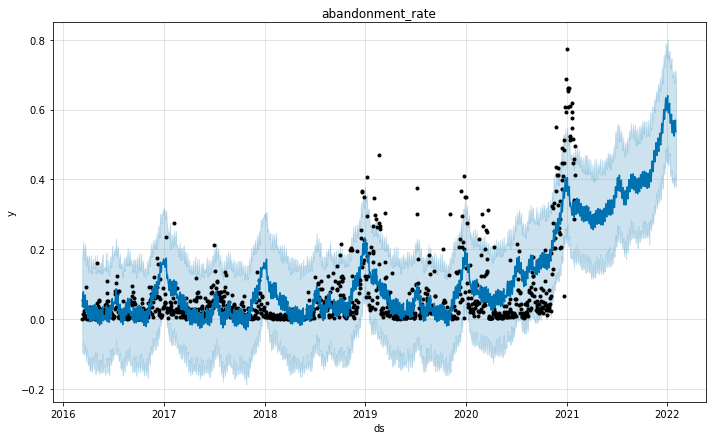

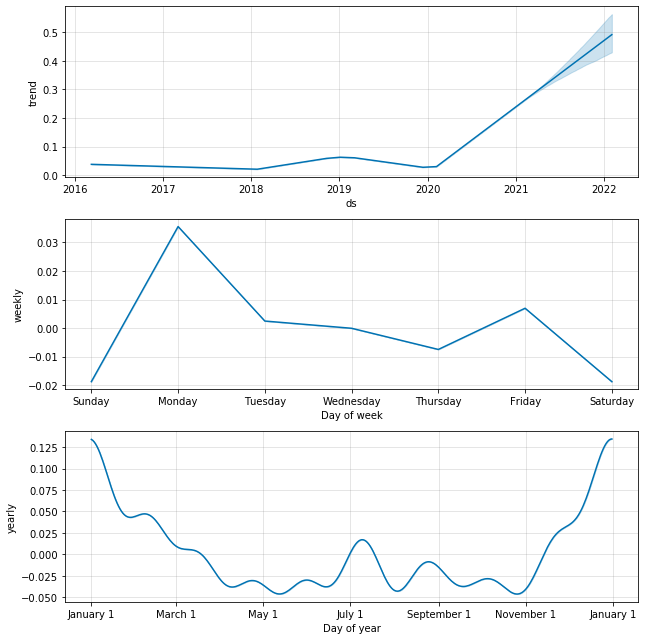

abandonment_rate


,ds,yhat_lower,yhat,yhat_upper,abandonment_rate,error_prophet
0,2021-02-03,0.162240,0.305906,0.449699,0.323271,0.017365
1,2021-02-04,0.157683,0.299702,0.447908,0.260305,0.039397
2,2021-02-05,0.178725,0.315251,0.464353,0.219834,0.095417
3,2021-02-08,0.212859,0.346185,0.492669,0.448515,0.102330
4,2021-02-09,0.167422,0.313401,0.464337,0.356673,0.043271
5,2021-02-10,0.171686,0.310927,0.450610,0.254337,0.056590
6,2021-02-11,0.158587,0.303296,0.442607,0.208070,0.095226


mape RIS_aht_vol.csv


,volume,aht,handle_time
old model,23.478573,3.521545,81.948886
prophet,8.815413,3.324699,13.101043
difference,14.663159,0.196845,68.847843


In [23]:
data = ['BRO_aht_vol.csv',
 'WISE-Contractual_aht_vol.csv',
 'CS-National_aht_vol.csv',
 'CS-Alaska_aht_vol.csv',
 'RIS_aht_vol.csv',
 'PSG_aht_vol.csv',
 'BRO-Complex_aht_vol.csv',
 'RCS-PHONES_aht_vol.csv',
 'CS-Maryland_aht_vol.csv',
 'CS-John-Hancock_aht_vol.csv']

data = ['RIS_aht_vol.csv']
performance = get_performance(data, 
                                    ['volume', 'aht','handle_time', 'abandonment_rate'] , 
                                    '2019-01-01', '2021-02-03', '2021-02-12', metric='mape')

In [6]:
# # run method for any business unit, kpi, and start and end date of testing
# m, diff, forecast = get_performance(['RIS_aht_vol.csv'], ['handle_time'], '2020-06-01', '2021-01-18')